# Step3

In [1]:
import pandas as pd
import statsmodels.api as sm

In [2]:
summer_df = pd.read_csv('SUMMER_TRAINING_DATA.csv')
winter_df = pd.read_csv('WINTER_TRAINING_DATA.csv')
shoulder_df = pd.read_csv('SHOULDER_TRAINING_DATA.csv')

In [3]:
# Extract the day of the week
summer_df['dateTimeStmp'] = pd.to_datetime(summer_df['dateTimeStmp'])
summer_df['DayOfWeek'] = summer_df['dateTimeStmp'].dt.day_name()
winter_df['dateTimeStmp'] = pd.to_datetime(winter_df['dateTimeStmp'])
winter_df['DayOfWeek'] = winter_df['dateTimeStmp'].dt.day_name()
shoulder_df['dateTimeStmp'] = pd.to_datetime(shoulder_df['dateTimeStmp'])
shoulder_df['DayOfWeek'] = shoulder_df['dateTimeStmp'].dt.day_name()

In [4]:
# Create dictionary, and traverse weekdays
seasons = {
    'Summer': summer_df,
    'Winter': winter_df,
    'Shoulder': shoulder_df
}

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Define independent and dependent varibles
dependent_var = 'raw_MM_Wh'
independent_vars = ['D-3', 'D-2', 'D-1', 'D+1', 'D+2', 'D+3']
results = {day: {} for day in days}

In [5]:
for day in days:
    for season, df in seasons.items():
        # Filter the data for the corresponding week of the season
        df_day = df[df['DayOfWeek'] == day].copy()
        if df_day.empty:
            continue

        # Data on independent and dependent variables
        X = df_day[independent_vars]
        X = sm.add_constant(X)
        y = df_day[dependent_var]

        # Perform OLS regression
        model = sm.OLS(y, X).fit()

        # Save regression results
        results[day][season] = {
            'params': model.params,
            'tvalues': model.tvalues,
            'r_squared': model.rsquared
        }


In [6]:
# Generate 7 tables
def create_result_table_for_day(results_day):
    season_order = ['Summer', 'Winter', 'Shoulder']
    rows = []

    for season in season_order:
        if season in results_day:
            res = results_day[season]
            row = {}
            for param in res['params'].index:
                row[f'coef_{param}'] = res['params'][param]
                row[f't_{param}'] = res['tvalues'][param]
                row['R_squared'] = res['r_squared']
        else:
            row = {}
            for param in ['const'] + independent_vars:
                row[f'coef_{param}'] = None
                row[f't_{param}'] = None
            row['R_squared'] = None
        row['Season'] = season
        rows.append(row)

    df_result = pd.DataFrame(rows)
    df_result.set_index('Season', inplace=True)
    return df_result

# Generate a table for each day and save it in the dictionary
tables = {}
for day in days:
    tables[day] = create_result_table_for_day(results[day])

In [7]:
for day in days:
    print(f"====== {day} ======")
    print(tables[day])
    print()

====== Monday ======
           coef_const   t_const  R_squared  coef_D-3     t_D-3  coef_D-2  \
Season                                                                     
Summer    1036.012227  6.458778   0.782749  0.115118  6.029591 -0.092982   
Winter    -139.120569 -2.292964   0.868061  0.103803  8.088442  0.087218   
Shoulder   381.151518  5.299355   0.866298  0.120037  8.346367  0.017473   

             t_D-2  coef_D-1      t_D-1  coef_D+1      t_D+1  coef_D+2  \
Season                                                                   
Summer   -4.152924  0.311613  16.848212  0.594105  31.165121 -0.040467   
Winter    6.399878  0.161685  12.668057  0.302617  19.876039  0.230215   
Shoulder  1.098692  0.314512  22.533116  0.411539  22.914647  0.136910   

              t_D+2  coef_D+3     t_D+3  
Season                                   
Summer    -1.773758  0.068701  4.086566  
Winter    16.354019  0.129762  9.629910  
Shoulder   8.007763 -0.044488 -3.091342  

====== Tuesday =

In [9]:
# # Export
# for day, table in tables.items():
#     filename = f'{day}_regression_results.csv'
#     table.to_csv(filename, index=True)

# Step4

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Combine dict of DataFrames into a single DataFrame, adding ordered 'Weekday' column
results_df = pd.concat([
    df.reset_index().assign(Weekday=pd.Categorical([day]*len(df), categories=weekday_order, ordered=True))
    for day, df in tables.items()
], ignore_index=True)

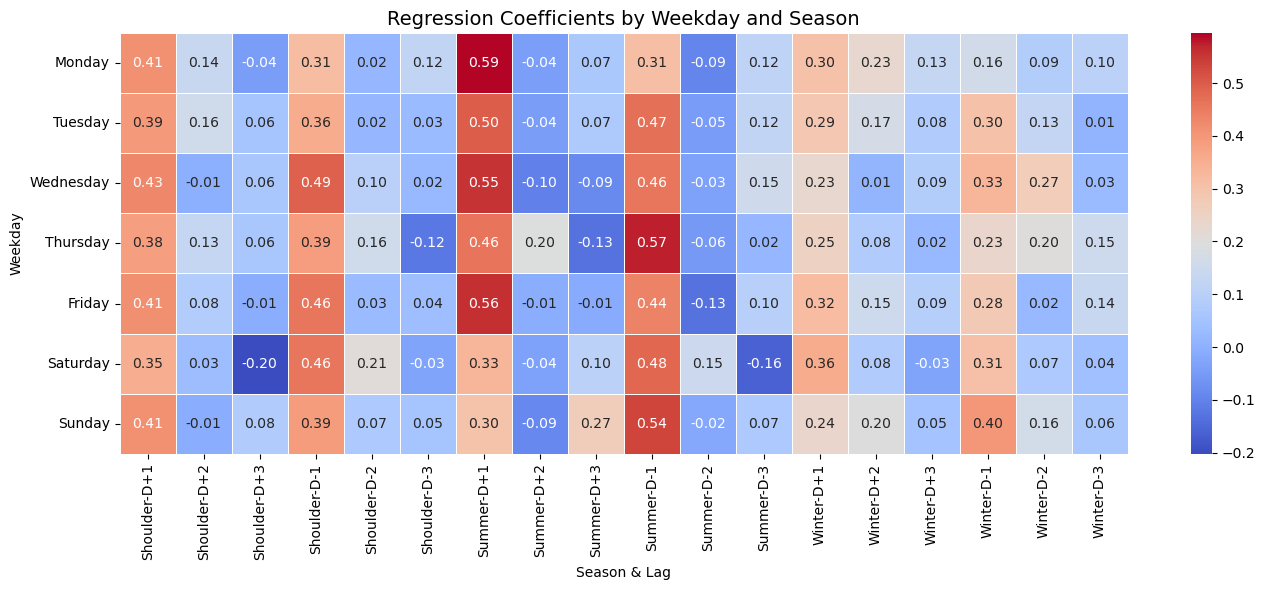

In [21]:
# -----------------------------
# Heatmap: Regression Coefficients (D-3 to D+3)
# -----------------------------
# Rename columns to consistent format
results_df = results_df.rename(columns={
    'coef_D-3': 'D-3', 'coef_D-2': 'D-2', 'coef_D-1': 'D-1',
    'coef_D+1': 'D+1', 'coef_D+2': 'D+2', 'coef_D+3': 'D+3',
    'R_squared': 'R2'
})

# Melt the DataFrame for heatmap
lag_cols = ['D-3', 'D-2', 'D-1', 'D+1', 'D+2', 'D+3']
df_melted = results_df.reset_index().melt(
    id_vars=['Weekday', 'Season'],
    value_vars=lag_cols,
    var_name='Lag',
    value_name='Coefficient'
)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    df_melted.pivot_table(index='Weekday', columns=['Season', 'Lag'], values='Coefficient'),
    annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5
)
plt.title("Regression Coefficients by Weekday and Season", fontsize=14)
plt.xlabel("Season & Lag")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()

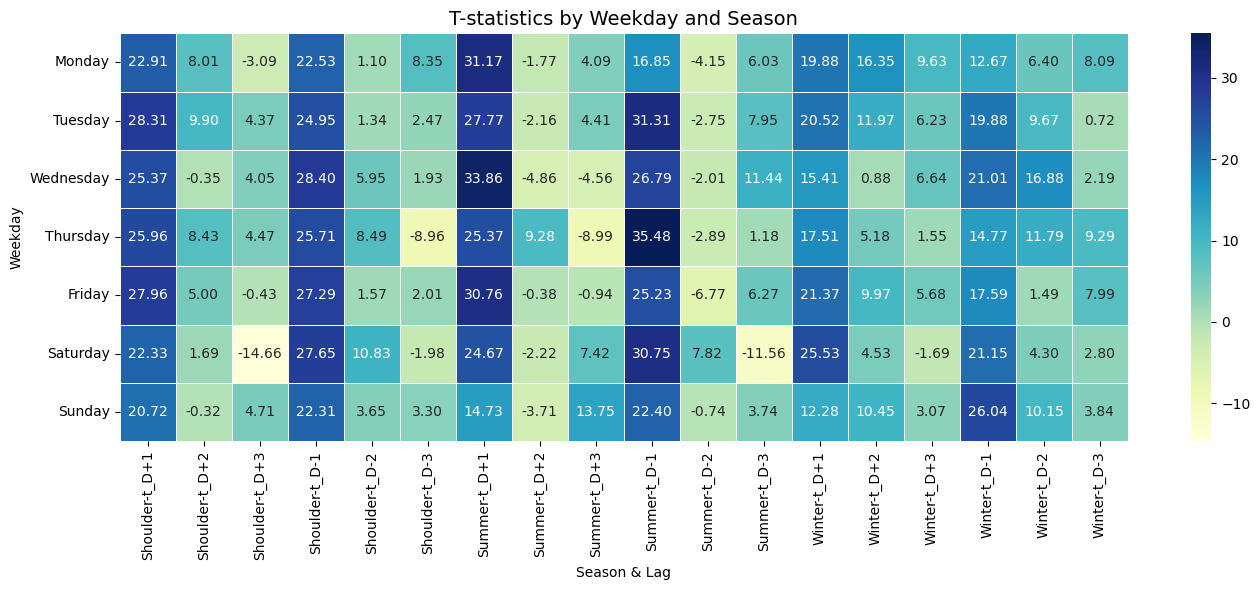

In [23]:
# t-statistics columns
tstat_cols = ['t_D-3', 't_D-2', 't_D-1', 't_D+1', 't_D+2', 't_D+3']

# Melt to long format for heatmap
df_tstats = results_df.melt(
    id_vars=['Weekday', 'Season'],
    value_vars=tstat_cols,
    var_name='Lag',
    value_name='T-statistic'
)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(
    df_tstats.pivot_table(index='Weekday', columns=['Season', 'Lag'], values='T-statistic'),
    annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5
)
plt.title("T-statistics by Weekday and Season", fontsize=14)
plt.xlabel("Season & Lag")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


1. Using the two heat maps of regression coefficients and t-statistics, we can analyze the impact of each lagged variable on daily electricity consumption. They illustrate similar information so we simply focus on the regression coefficients.
2. In particular, some weekends (such as Shoulder_D+3 on Saturday) have extremely negative t values, indicating that the model has strong uncertainty and irregularity in predicting weekend electricity consumption.
3. Interestingly. The regression coefficients in winter are generally lower than those in other seasons, but the overall R² value (see below) of the model remains at a high level, reflecting that the winter electricity consumption pattern itself is more stable and less volatile.

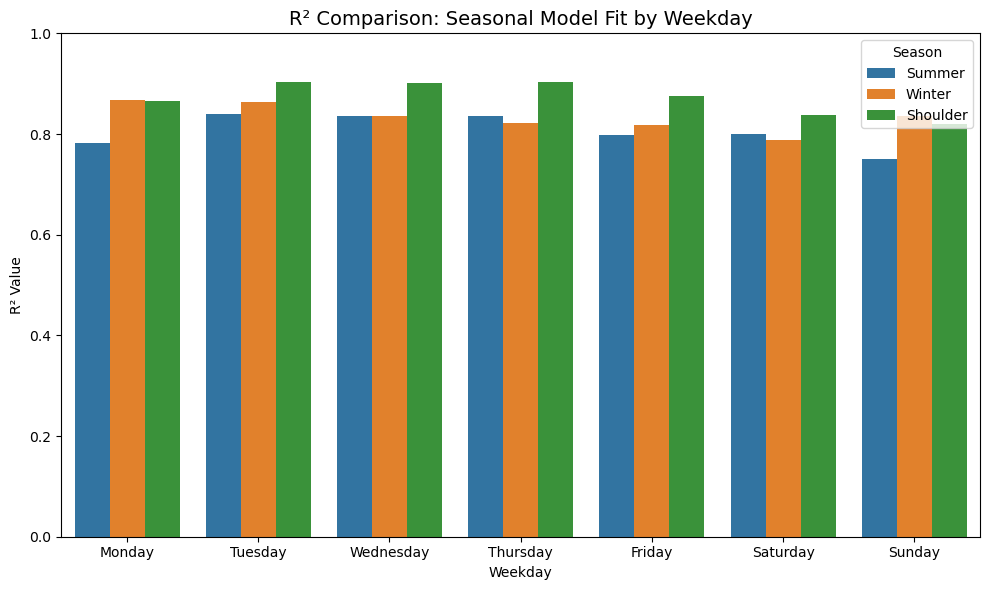

In [22]:
# Plot R² values for each weekday-season pair
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Weekday', y='R2', hue='Season')
plt.title("R² Comparison: Seasonal Model Fit by Weekday", fontsize=14)
plt.ylabel("R² Value")
plt.xlabel("Weekday")
plt.ylim(0, 1)
plt.legend(title='Season')
plt.tight_layout()
plt.show()

In [24]:
# Rename R_squared column if necessary
results_df = results_df.rename(columns={'R_squared': 'R2'})

# Compute averages
weekday_avg_r2 = results_df[results_df['Weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]['R2'].mean()
weekend_avg_r2 = results_df[results_df['Weekday'].isin(['Saturday', 'Sunday'])]['R2'].mean()

summer_avg_r2 = results_df[results_df['Season'] == 'Summer']['R2'].mean()
winter_avg_r2 = results_df[results_df['Season'] == 'Winter']['R2'].mean()
shoulder_avg_r2 = results_df[results_df['Season'] == 'Shoulder']['R2'].mean()

# Print results
print("Average R² for weekdays (Mon–Fri):", round(weekday_avg_r2, 4))
print("Average R² for weekends (Sat–Sun):", round(weekend_avg_r2, 4))
print("Average R² for Summer:", round(summer_avg_r2, 4))
print("Average R² for Winter:", round(winter_avg_r2, 4))
print("Average R² for Shoulder season:", round(shoulder_avg_r2, 4))

Average R² for weekdays (Mon–Fri): 0.8499
Average R² for weekends (Sat–Sun): 0.8048
Average R² for Summer: 0.8059
Average R² for Winter: 0.8325
Average R² for Shoulder season: 0.8727


1. The model of the Shoulder season has the best overall performance, and the R² value is generally higher than 0.85 in all weeks, indicating that electricity consumption behavior in spring and autumn is more stable and predictable, and the model is easier to fit.
2. In contrast, the models for Summer and Winter also perform well but slightly worse (R² is about 0.78 ~ 0.80), which is understandable based on the previous analysis of temperature. Because the shoulder season is often a period of stable temperature rise or fall, while the temperature in summer and winter fluctuates at a certain level.
3. It is also worth mentioning that the model fitting effect on weekdays is slightly better than that on weekends, with the R² value approaching or reaching 0.9, indicating that the electricity consumption pattern on weekdays has stronger consistency and regularity, which is the time when the model can perform best. There may be uncertainty on the weekend due to travel or other reasons.

## Thank you